## Historical Max Temperature from Tomorrow.io API for Delhi, India

We retrieve the max temperature (i.e., `temperatureMax`) for Delhi, India on [H3 resolution 7](https://h3geo.org) from the [Historical](https://docs.tomorrow.io/reference/historical) data layer of the [Tomorrow.io API](https://docs.tomorrow.io/reference/api-introduction).

In [1]:
import asyncio
import json
import os
from typing import Optional

import geopandas
import h3
import pandas as pd
import shapely
from aiohttp import ClientSession
from shapely.geometry import Polygon

The following are auxiliary function(s). Ideally, these will be packaged in an opportune moment.

In [2]:
def get_h3_tessellation(
    gdf: geopandas.GeoDataFrame, name="shapeName", resolution=10
) -> geopandas.GeoDataFrame:
    mapper = dict()
    tiles = set()

    # TODO: vectorize, if possible
    for idx, row in gdf.iterrows():
        geometry = row["geometry"] 
        match geometry.geom_type:
            case "Polygon":
                hex_ids = h3.polyfill(
                    shapely.geometry.mapping(geometry),
                    resolution,
                    geo_json_conformant=True,
                )

                tiles = tiles.union(set(hex_ids))
                mapper.update([(hex_id, row[name]) for hex_id in hex_ids])

            case "MultiPolygon":
                for x in geometry.geoms:
                    hex_ids = h3.polyfill(
                        shapely.geometry.mapping(x),
                        resolution,
                        geo_json_conformant=True,
                    )

                    tiles = tiles.union(set(hex_ids))
                    mapper.update([(hex_id, row[name]) for hex_id in hex_ids])
            case _:
                raise (Exception)

    tessellation = geopandas.GeoDataFrame(
        data=tiles,
        geometry=[Polygon(h3.h3_to_geo_boundary(idx, True)) for idx in tiles],
        columns=["hex_id"],
        crs="EPSG:4326",
    )

    return tessellation

In [3]:
# create the Tomorrow.io API token at https://app.tomorrow.io/development/keys
TOMORROW_API_KEY = ''#os.getenv("uyOL03vZtbjfkTwKIRFyzO1HOcgoigaa")

## Area of Interest: Vietnam

In [4]:
import os
os.getcwd()

'c:\\Users\\sahit\\OneDrive\\Documents\\01 World Bank\\India\\india-vulnerability-to-heatwaves\\notebooks'

In [5]:
DELHI = geopandas.read_file("../data/Delhi-Shapefile/mw277wc3858.shp")
DELHI = DELHI[DELHI['name_1']=='NCT of Delhi']
delhi_district = geopandas.read_file("../data/india_district/sh819zz8121.shp")

In [16]:
VIETNAM = geopandas.read_file('../data/vietname admin/vnm_adm_gov_20201027/vnm_admbnda_adm2_gov_20201027.shp')
VINH = VIETNAM[VIETNAM['ADM2_EN']=='Vinh']

In [12]:
affected_areas_list = ['Ha Tinh','Hue', 'Lao Cai', 'Phy Ly', 'Vinh']

In [13]:
affected_areas = VIETNAM[VIETNAM['ADM2_EN'].isin(affected_areas_list)]

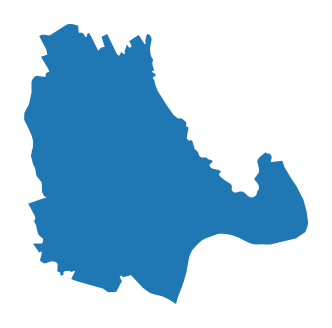

In [14]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(6, 4))
VIETNAM[VIETNAM['ADM2_EN']=='Vinh'].plot(ax=ax)

ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.tick_params(axis=u'both', which=u'both',length=0, labelbottom = False, labelleft=False)


In [15]:
affected_areas.explore()

## Tessellation in H3

In this step, we generate a tessellation layer for the **area of interest** using [H3 resolution 7](https://h3geo.org).

In [18]:
TESSELLATION = get_h3_tessellation(VINH, name="ADM2_EN", resolution=7)

In [19]:
TESSELLATION.explore()

In [20]:
TESSELLATION["geojson"] = TESSELLATION["geometry"].apply(
    lambda x: json.dumps(shapely.geometry.mapping(x))
)

## Retrieve `Historical` from Tomorrow.io API

> Tomorrow.io's Historical Weather API allows you to query weather conditions (limited to historical data layers ]) by specifying the location (GeoJSON of a Point, LineString or Polygon), fields ("temperature", "windSpeed", ...), timesteps ("1h", "1d") and the startTime and endTime, such that the response include a historical timeline.

    Polygon and Polyline limits:

    Polygon - 10,000 square km and no more than 70km per segment.
    Polyline - 2,000 km long.
    Max number of vertices - 550.
    Timerange is limited to up to 30 days per API call.

    If the location is a Polygon or a Polyline, you can specify whether you want the min/max/avg values throughout that coverage area by adding them as a suffix to any of the available fields (temperatureMax, temperatureMaxTime) and if not specified the response will default to Max.

    The historical archive is based on a reanalysis model that blends past short-range weather forecasts with observations through advanced data assimilation techniques. The historical archive data deviates from the recent historical data -7 days since it is based on a different observation data assimilation system that incorporates a larger set of final observational records.
    Please note that our reanalysis model takes between 7 to 90 days to calculate the data fields. Please see the historical data field Availability.

    See also: https://docs.tomorrow.io/reference/historical-overview

In [21]:
class TomorrowAPIClient:
    """An Asynchronous API client for Tomorrow.io API"

    Parameters
    ----------
    token : str
        Tomorrow.io API token

    Notes
    -----
    For more information, please see https://docs.tomorrow.io
    """

    BASE_URL = "https://api.tomorrow.io/v4"

    def __init__(
        self, session: Optional[ClientSession] = None, token: Optional[str] = None
    ):
        self.session = session or ClientSession()
        self.semaphore = asyncio.BoundedSemaphore(4)
        self.token = token or os.getenv("TOMORROW_TOKEN")

    async def __aenter__(self):
        return self

    async def __aexit__(self, *args):
        await self.close()

    async def close(self):
        await self.session.close()

    async def post(self, url, json, params={}, headers={}):
        params["apikey"] = self.token
        async with self.semaphore, self.session.post(
            url, json=json, params=params, headers=headers
        ) as response:
            return await response.json()

### Creating `intervals`

Let's start in 2021, from January 1st to December 31th. The Tomorrow.io API limits the date range to 30 days. Thus, we create 13 periods of 28 days and add 1 day to the last period.

In [45]:
date_range = pd.date_range("2023-04-01", "2023-04-10", periods=4)
intervals = list(zip(date_range, date_range[1:]))

Fix by adding last day, 

In [16]:
intervals[-1] = (pd.Timestamp("2022-06-30"), pd.Timestamp("2022-03-24"))

In [46]:
intervals

[(Timestamp('2023-04-01 00:00:00'), Timestamp('2023-04-04 00:00:00')),
 (Timestamp('2023-04-04 00:00:00'), Timestamp('2023-04-07 00:00:00')),
 (Timestamp('2023-04-07 00:00:00'), Timestamp('2023-04-10 00:00:00'))]

### Create `payloads`

In [55]:
payloads = [
    {
        "location": location,
        "fields": ["temperatureMax"],
        "timesteps": ["7d"],
        "startTime": startTime.isoformat(),
        "endTime": endTime.isoformat(),
        "units": "metric",
    }
    for location in TESSELLATION["geojson"]
    for (startTime, endTime) in intervals
]

Just checking the cardinality,

In [56]:
len(payloads) == len(TESSELLATION) * len(intervals)

True

Now, let's call the Tomorrow.io API!

In [57]:
print(TOMORROW_API_KEY)

uyOL03vZtbjfkTwKIRFyzO1HOcgoigaa


In [58]:
async with TomorrowAPIClient(token=TOMORROW_API_KEY) as client:

    url = f"https://api.tomorrow.io/v4/historical"
    headers = {"Accept": "application/json", "Content-Type": "application/json"}

    futures = [client.post(url, json=payload, headers=headers) for payload in payloads]
    vihn_tmax = await asyncio.gather(*futures)

In [59]:
vihn_tmax

[{'code': 400001,
  'type': 'Invalid Body Parameters',
  'message': "The entries provided as body parameters were not valid for the request. Fix Body and try again: 'timesteps' - timestep value is not allowed"},
 {'code': 400001,
  'type': 'Invalid Body Parameters',
  'message': "The entries provided as body parameters were not valid for the request. Fix Body and try again: 'timesteps' - timestep value is not allowed"},
 {'code': 400001,
  'type': 'Invalid Body Parameters',
  'message': "The entries provided as body parameters were not valid for the request. Fix Body and try again: 'timesteps' - timestep value is not allowed"},
 {'code': 400001,
  'type': 'Invalid Body Parameters',
  'message': "The entries provided as body parameters were not valid for the request. Fix Body and try again: 'timesteps' - timestep value is not allowed"},
 {'code': 400001,
  'type': 'Invalid Body Parameters',
  'message': "The entries provided as body parameters were not valid for the request. Fix Body an

## Data Manipulation

In [164]:
for i in [0,124]:
    item = data[i]
    dataframes = pd.json_normalize(item["data"]["timelines"][0]["intervals"])

In [112]:
import ast
dataframes =  pd.json_normalize(dict(data[0])['data']['timelines'][0]['intervals'])

In [153]:
dataframes = [pd.json_normalize(item["data"]["timelines"][0]["intervals"]) for item in data[0:124]]

KeyError: 'data'

Concatenating,

In [165]:
df = pd.concat(dataframes)
df

TypeError: first argument must be an iterable of pandas objects, you passed an object of type "DataFrame"

In [166]:
dataframes

,startTime,values.temperatureMax
0,2022-08-12T00:00:00Z,32.32
1,2022-08-13T00:00:00Z,32.48
2,2022-08-14T00:00:00Z,31.87
3,2022-08-15T00:00:00Z,29.72
4,2022-08-16T00:00:00Z,28.16
5,2022-08-17T00:00:00Z,30.55
6,2022-08-18T00:00:00Z,31.84
7,2022-08-19T00:00:00Z,31.75
8,2022-08-20T00:00:00Z,31.57
9,2022-08-21T00:00:00Z,32.71
